<a href="https://colab.research.google.com/github/IEXE-Tec/mcda-fintech/blob/master/time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Return Prediction

En este Notebook veremos varios algoritmos de Aprendizaje Supervisado para predecir el precio de las acciones de Microsost usando assets correlacionados y datos historicos.

Utilizaremos datos historicos de Microsoft, y variables independientes que pueden ser assests correlacionados:
* Stocks: IBM (IBM) and Alphabet (GOOGL)
* Currency: USD/JPY and GBP/USD
* Indices: S&P 500, Dow Jones and VIX

Trataremos de predecir los retornos semanales: Mas o menos equivalen a 5 dias de la semana.

# Librerias

In [ ]:
#Librerias
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Modelos de Deep Learning
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

#Librerias Estadisticas
import statsmodels.api as sm

#Salvar y guardar Modelos
from pickle import dump
from pickle import load

# Modelos de Series de Tiempo
from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Metricas de Error
from sklearn.metrics import mean_squared_error

# Seleccion de Variables
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression


#Graficar 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Eliminar Warnings

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# ETL

In [ ]:
stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']

stk_data = web.DataReader(stk_tickers, 'yahoo')
ccy_data = web.DataReader(ccy_tickers, 'fred')
idx_data = web.DataReader(idx_tickers, 'fred')

In [ ]:
return_period = 5

Separamos el target y las features.
Creamos la serie de tiempo.

Todas las variables exceptuando MSFT estan laggeadas 5 dias.  
Ademas tenemos lags de MSFT para 5, 15, 30, y 60 dias.

In [ ]:
stk_data

Attributes   Adj Close              ...     Volume           
Symbols           MSFT         IBM  ...        IBM      GOOGL
Date                                ...                      
2016-06-27   44.616528  114.900169  ...  5017900.0  2907300.0
2016-06-28   45.546997  116.661713  ...  3997700.0  1912300.0
2016-06-29   46.560383  118.871620  ...  3367700.0  2156200.0
2016-06-30   47.140781  121.529945  ...  3967100.0  2112500.0
2016-07-01   47.131561  121.986351  ...  2658300.0  1549200.0
...                ...         ...  ...        ...        ...
2021-06-18  259.429993  143.119995  ...  9149600.0  2286700.0
2021-06-21  262.630005  146.649994  ...  4285500.0  1370700.0
2021-06-22  265.510010  146.360001  ...  2437000.0  1119500.0
2021-06-23  265.269989  144.610001  ...  3200900.0   957400.0
2021-06-24  266.119904  145.570007  ...  2365281.0   654848.0

[1258 rows x 18 columns]

In [ ]:
Y = np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(return_period).shift(-return_period)
Y.name = Y.name[-1]+'_pred'

# Transformaciones logaritmicas
X1 = np.log(stk_data.loc[:, ('Adj Close', ('GOOGL', 'IBM'))]).diff(return_period)
X1.columns = X1.columns.droplevel()
X2 = np.log(ccy_data).diff(return_period)
X3 = np.log(idx_data).diff(return_period)

X4 = pd.concat([np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(i) for i in [return_period,
                                        return_period*3, return_period*6, return_period*12]], axis=1).dropna()
X4.columns = ['MSFT_DT', 'MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']

X = pd.concat([X1, X2, X3, X4], axis=1)

dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.name]
X = dataset.loc[:, X.columns]

In [ ]:
dataset.shape

(225, 12)

# EDA

In [ ]:
pd.set_option('precision', 3)
dataset.describe()

,MSFT_pred,IBM,GOOGL,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
count,225.000,2.250e+02,225.000,2.250e+02,2.250e+02,225.000,225.000,225.000,225.000,225.000,225.000,225.000
mean,0.007,-1.251e-04,0.005,2.263e-04,7.550e-05,0.002,0.002,0.003,0.007,0.020,0.039,0.081
std,0.029,3.237e-02,0.035,1.085e-02,1.317e-02,0.022,0.025,0.167,0.031,0.049,0.058,0.070
min,-0.105,-1.304e-01,-0.132,-4.010e-02,-9.152e-02,-0.134,-0.169,-0.485,-0.104,-0.198,-0.246,-0.144
25%,-0.009,-1.292e-02,-0.012,-5.649e-03,-6.712e-03,-0.003,-0.006,-0.094,-0.010,-0.003,0.009,0.041
50%,0.007,3.080e-03,0.005,1.822e-04,2.551e-04,0.004,0.004,-0.014,0.007,0.024,0.040,0.082
75%,0.025,1.754e-02,0.023,6.791e-03,8.231e-03,0.013,0.013,0.082,0.026,0.048,0.075,0.124
max,0.082,1.263e-01,0.145,3.579e-02,5.225e-02,0.107,0.112,0.707,0.101,0.186,0.227,0.346


In [ ]:
dataset.head()

,MSFT_pred,IBM,GOOGL,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
2016-09-21,0.005,0.010,0.018,-1.685e-02,-0.017,0.017,1.426e-02,-0.310,0.026,-0.002,-0.001,0.182
2016-09-28,-0.007,0.018,0.006,-4.970e-04,0.001,0.004,2.486e-03,-0.071,0.005,0.006,0.010,0.132
2016-10-05,-0.009,-0.008,-0.011,2.901e-02,-0.020,-0.005,-3.179e-03,0.047,-0.007,0.024,-0.004,0.086
2016-10-13,0.006,-0.020,0.001,-3.853e-03,-0.036,-0.013,-9.325e-03,0.262,-0.014,-0.016,-0.009,0.024
2016-10-21,0.004,-0.032,0.024,-1.346e-03,0.002,0.004,4.040e-04,-0.189,0.038,0.035,0.060,0.066


<Figure size 1080x1080 with 0 Axes>

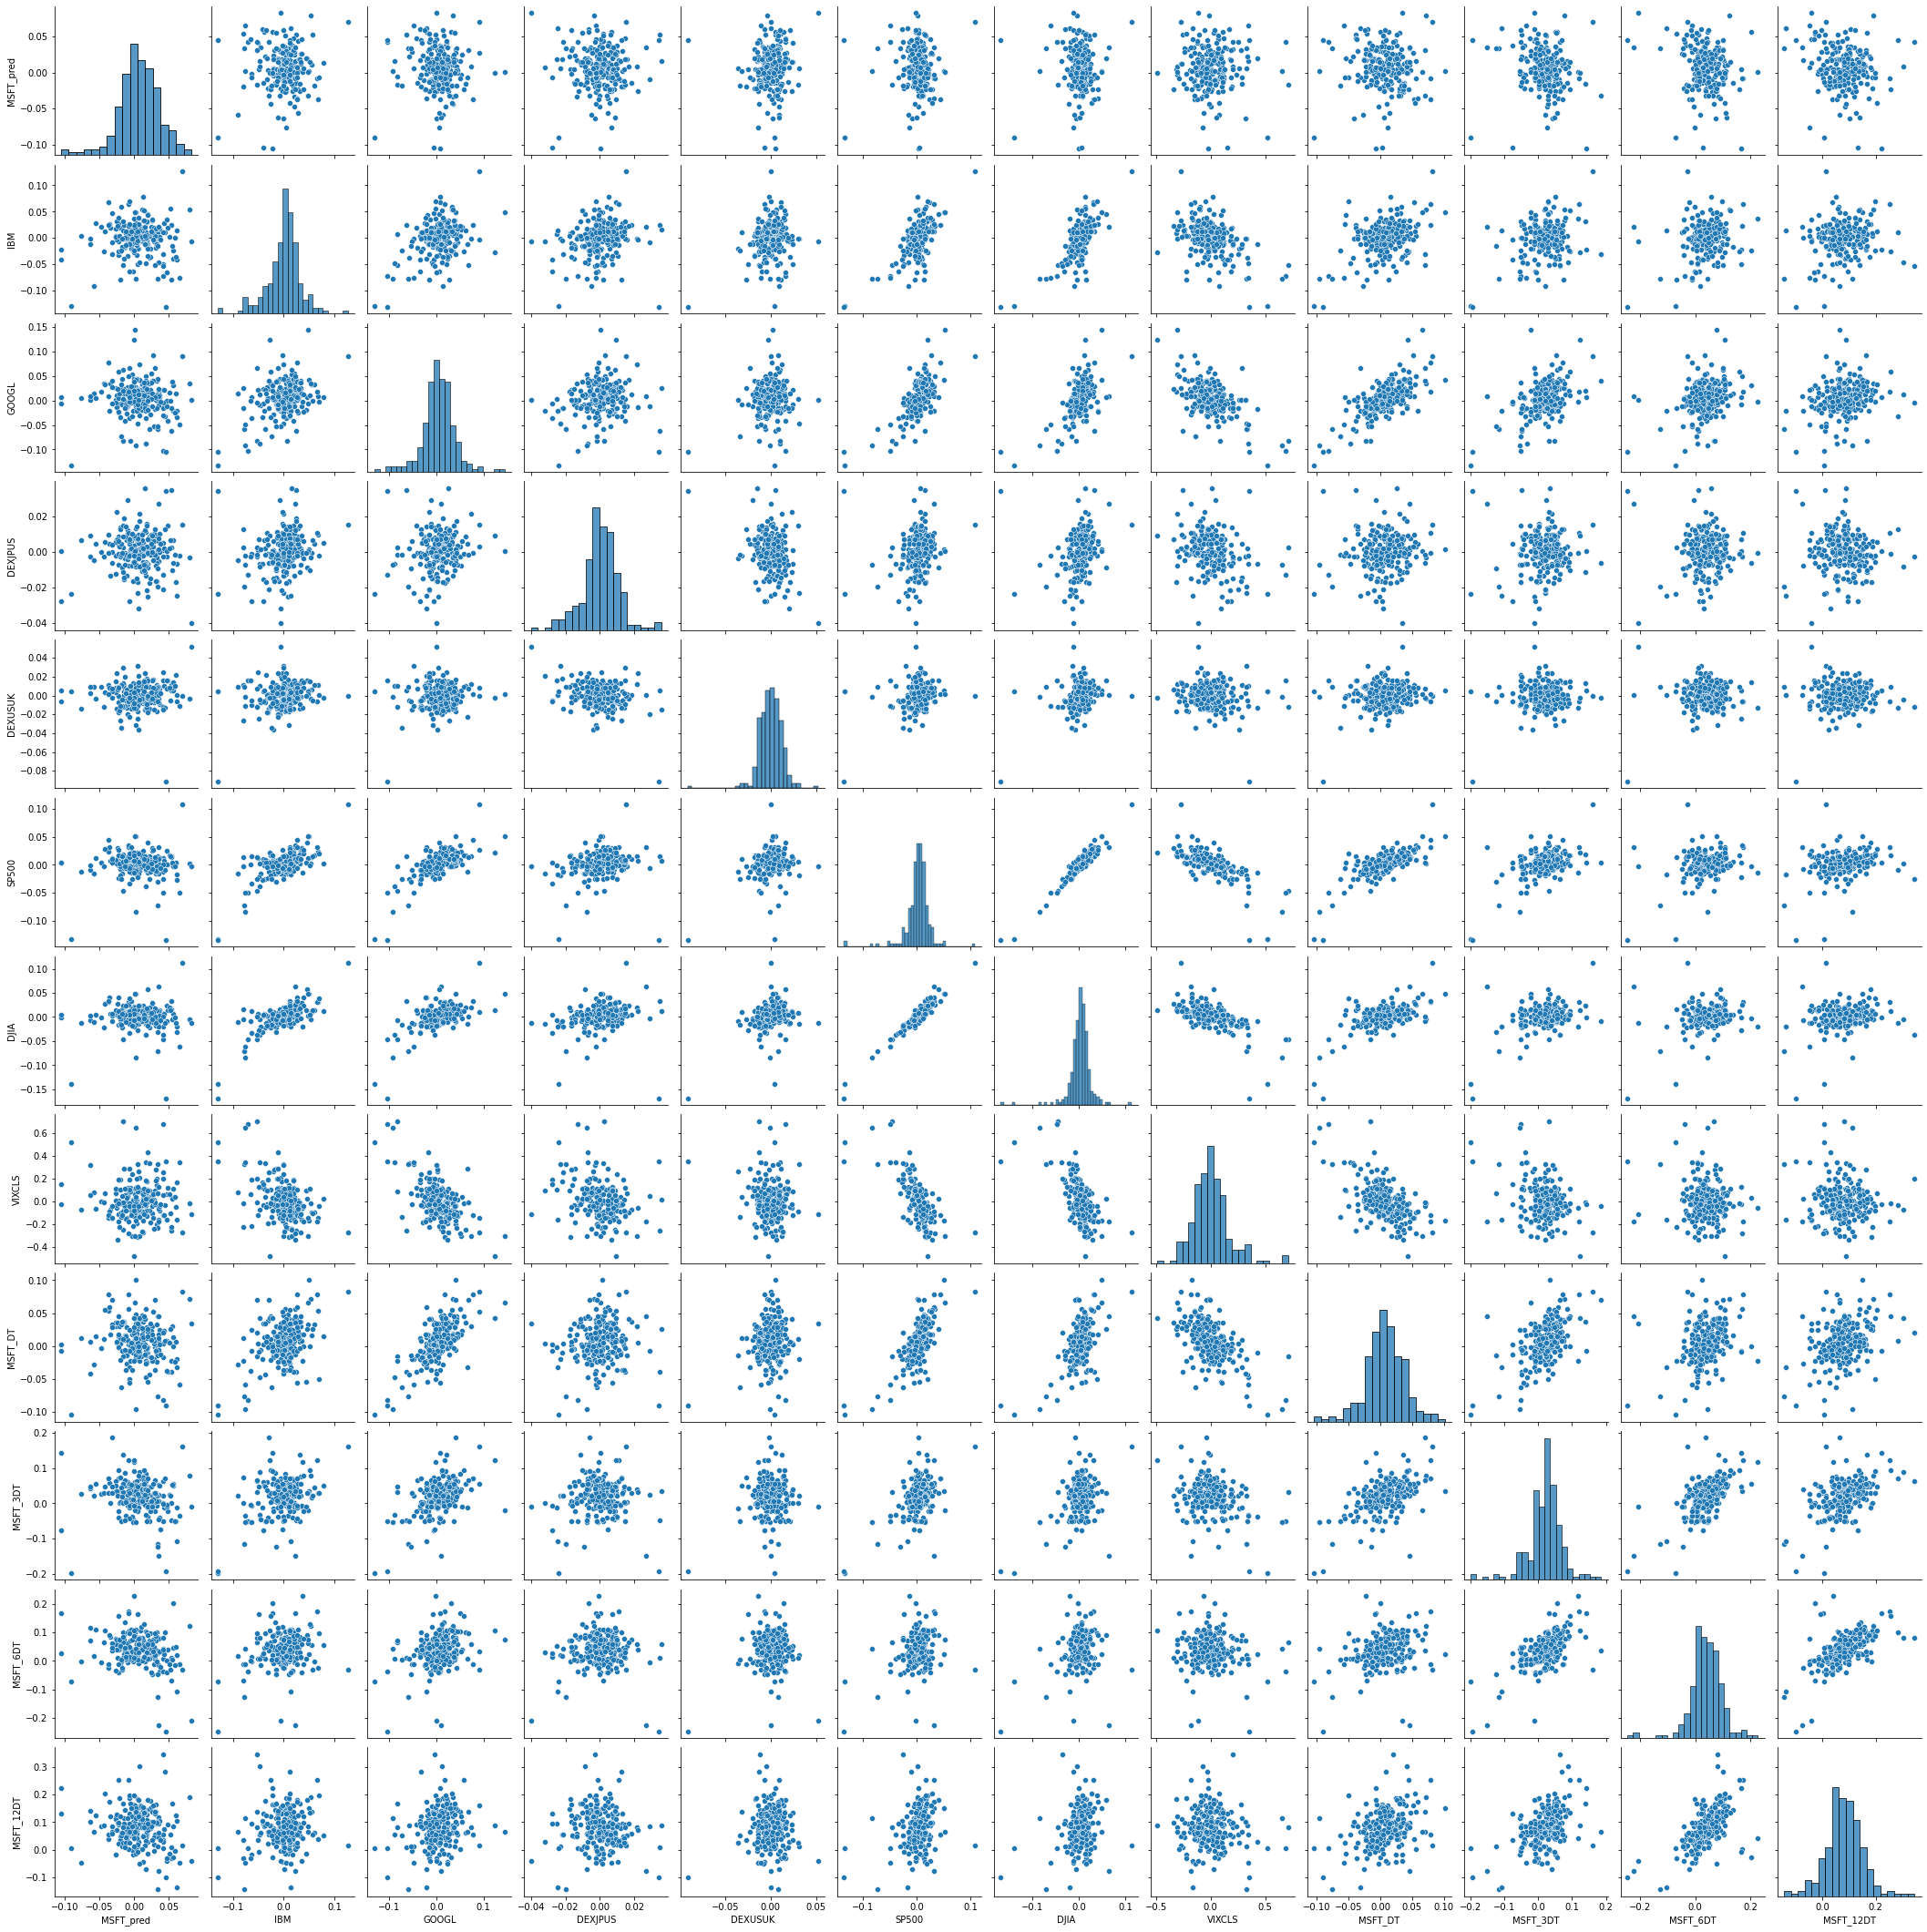

In [ ]:
pyplot.figure(figsize=(15,15))
sns.pairplot(dataset)

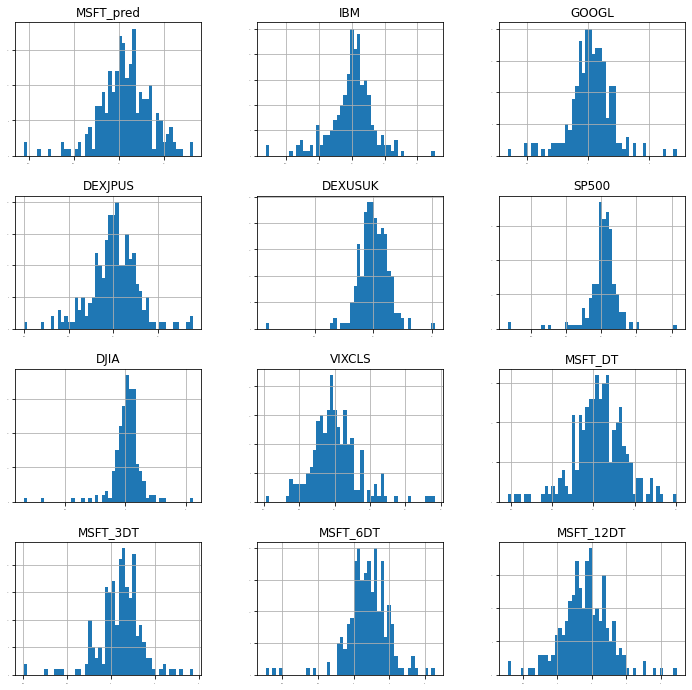

In [ ]:
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

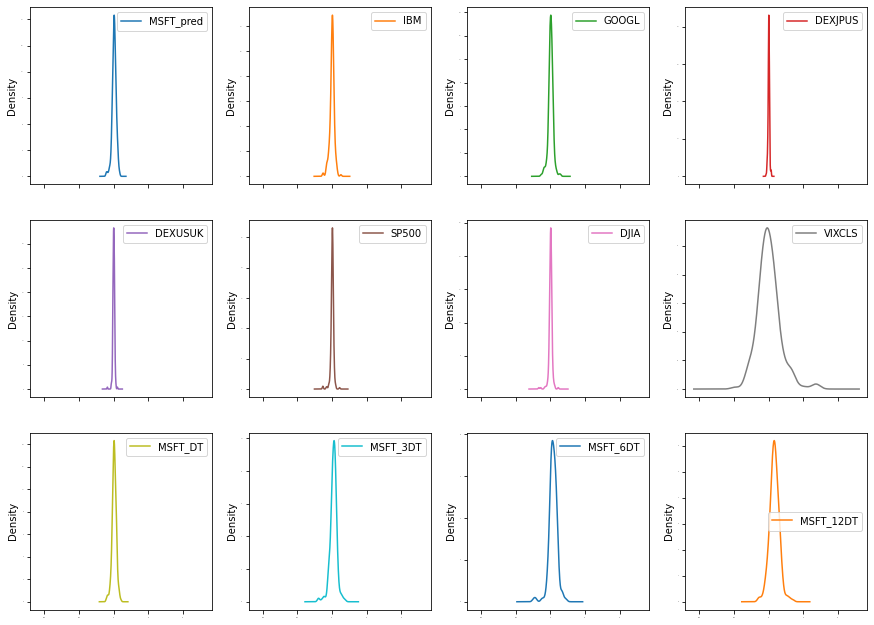

In [ ]:
dataset.plot(kind='density', subplots=True, layout=(4,4), sharex=True, legend=True, fontsize=1, figsize=(15,15))
pyplot.show()

VIX parece tener mayor varianza comaprada a las otras distribuciones.

## Correlaciones

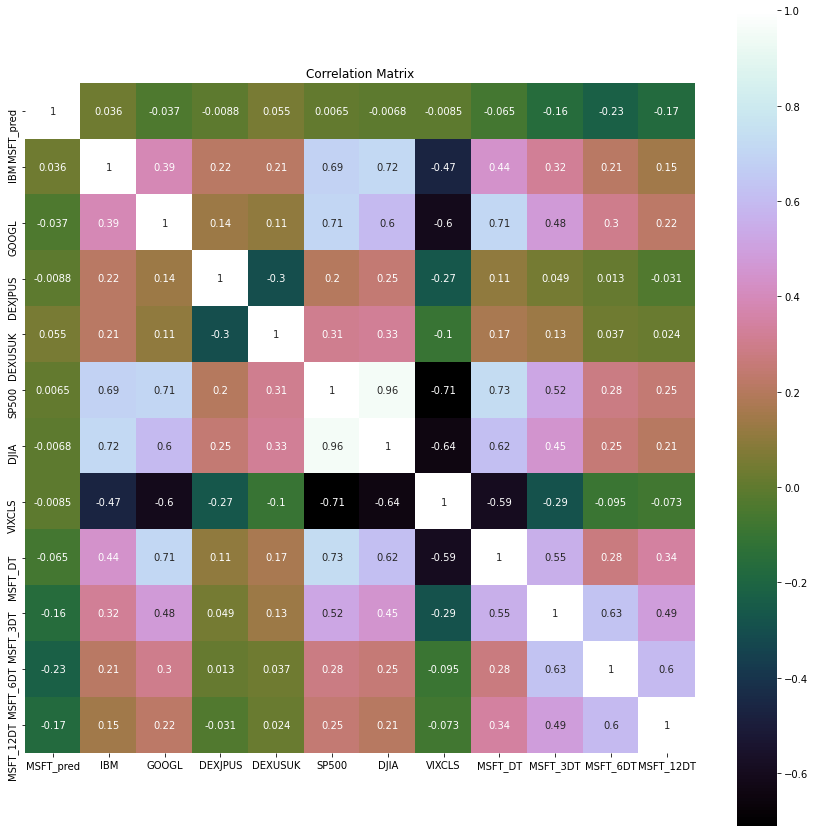

In [ ]:
correlation = dataset.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

Vemos que las correlaciones mas altas son respecto a sus variables laggeadas.

# EDA Series de Tiempo

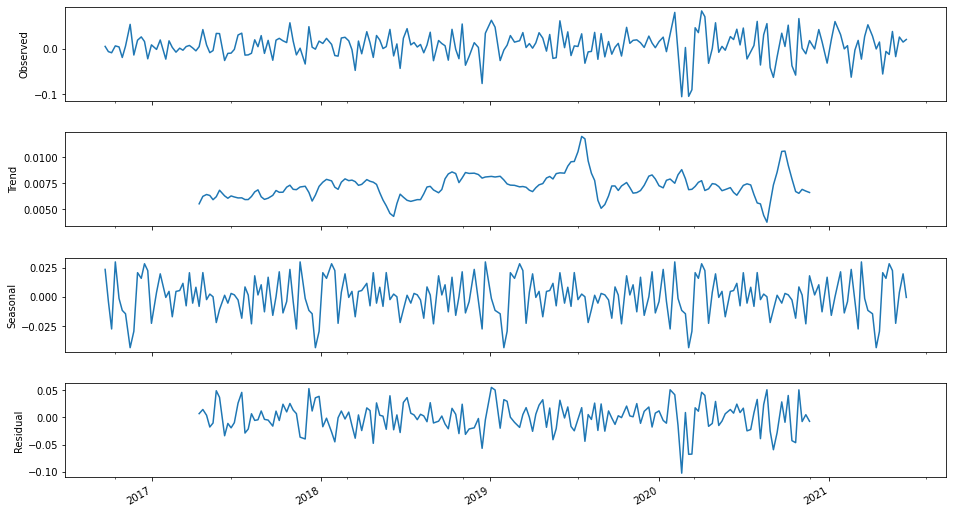

In [ ]:
res = sm.tsa.seasonal_decompose(Y,freq=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

Podemos observar que el trend es un poco a la baja o constante en los ultimos dias.

# Feature Selection

Usemos [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html) para seleccionar las mejores variables.

In [ ]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

# Visualizaciones
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.nlargest(10,'Score').set_index('Specs')  #print 10 best features

,Score
Specs,
MSFT_6DT,11.940
MSFT_12DT,6.730
MSFT_3DT,5.988
MSFT_DT,0.942
DEXUSUK,0.665
GOOGL,0.310
IBM,0.287
DEXJPUS,0.017
VIXCLS,0.016


# Modelos

## Separemos los datos de Manera Adecuada

Dividamos los Datos de Manera Educada!

Ordenemoslos por timestamp (que es le indice).

In [ ]:
X = X.sort_index(ascending=True)
X.reset_index(drop=True, inplace=True)
Y = Y.sort_index(ascending=True)
Y.reset_index(drop=True, inplace=True)

In [ ]:
n_blind = 5
n_test = 10

#Test
X_test = X[-n_test:]
Y_test = Y[-n_test:]
# Train
X_train = X[:-n_test]
Y_train = Y[:-n_test]


In [ ]:
from sklearn.model_selection import TimeSeriesSplit
test_size = 0.2

tscv = TimeSeriesSplit(n_splits=5)
print(tscv)
split_idx = []
for train_index, test_index in tscv.split(X_train):
    #print("TRAIN:", train_index, "TEST:", test_index)
    #X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    split_idx.append((train_index, test_index))

TimeSeriesSplit(max_train_size=None, n_splits=5)


In [ ]:
split_idx

[(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
         34, 35, 36, 37, 38, 39]),
  array([40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
         57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73,
         74])),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
         34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
         51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
         68, 69, 70, 71, 72, 73, 74]),
  array([ 75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,
          88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100,
         101, 102, 103, 104, 105, 106, 107, 108, 109])),
 (array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
          13,  

Originalmente obtuve un warning de que sklearn dejaria de utilisar el `rmse` y pasaria a utilizar `neg_mean_squared_error`

In [ ]:
num_folds = 10
seed = 7
scoring = 'neg_mean_squared_error'

## Modelos Clasicos

**Modelos Estandar**

In [ ]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))
models.append(('MLP', MLPRegressor()))

**Modelos de Boosting y Bagging**

In [ ]:
# Boosting 
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging 
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

### K-folds para eleccion de modelos

In [ ]:
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=split_idx, 
                                     scoring=scoring, n_jobs=-1)
    kfold_results.append(cv_results)
    

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), 
                                 train_result, test_result)
    print(msg)

LR: 0.001122 (0.000727) 0.000773 0.000690
LASSO: 0.000972 (0.000512) 0.000851 0.000667
EN: 0.000972 (0.000512) 0.000851 0.000667
KNN: 0.001069 (0.000562) 0.000660 0.000750
CART: 0.001612 (0.000911) 0.000000 0.001632
SVR: 0.001142 (0.000601) 0.001193 0.000816
MLP: 0.002421 (0.001509) 0.000925 0.000706
ABR: 0.001012 (0.000565) 0.000423 0.000863
GBR: 0.001163 (0.000658) 0.000094 0.000888
RFR: 0.001047 (0.000608) 0.000136 0.000973
ETR: 0.001059 (0.000609) 0.000000 0.000952


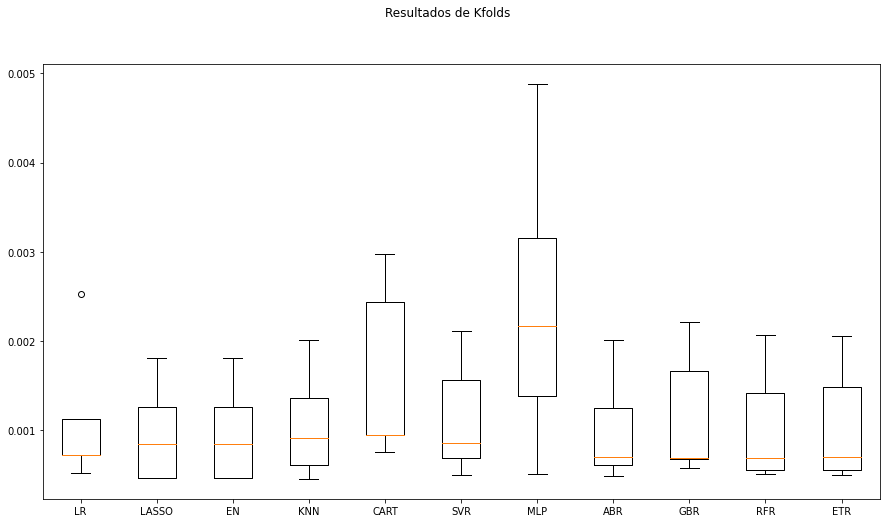

In [ ]:
fig = pyplot.figure()
fig.suptitle('Resultados de Kfolds')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

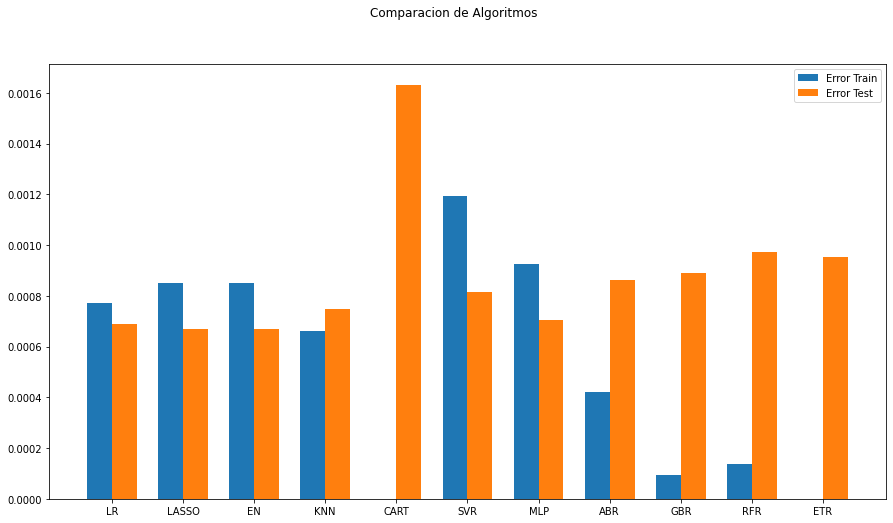

In [ ]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Comparacion de Algoritmos')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Error Train')
pyplot.bar(ind + width/2, test_results, width=width, label='Error Test')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

+ Parece que los modelos CART y ETR tiene muy buen performance en el train, pero pesimo en el test.  
+ Los modelos de **ensamble** como GBR y RF tienen **bias pequeño**, pero **varianza alta**

## Modelos de time Series

Documentacion [ARIMA](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html)

In [ ]:
X_train_ARIMA=X_train.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
X_test_ARIMA=X_test.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
tr_len = len(X_train_ARIMA)
te_len = len(X_test_ARIMA)
to_len = len (X)

In [ ]:
modelARIMA=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=[1,0,0])
model_fit = modelARIMA.fit()

In [ ]:
error_Training_ARIMA = mean_squared_error(Y_train, model_fit.fittedvalues)
predicted = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
error_Test_ARIMA = mean_squared_error(Y_test,predicted)
error_Test_ARIMA

0.0007380038125161113

## Deep Learning: LST

In [ ]:
#Tamaño de Secuencia de LSTM
seq_len = 2 

Y_train_LSTM, Y_test_LSTM = np.array(Y_train)[seq_len-1:], np.array(Y_test)
X_train_LSTM = np.zeros((X_train.shape[0]+1-seq_len, seq_len, X_train.shape[1]))
X_test_LSTM = np.zeros((X_test.shape[0], seq_len, X.shape[1]))
for i in range(seq_len):
    X_train_LSTM[:, i, :] = np.array(X_train)[i:X_train.shape[0]+i+1-seq_len, :]
    X_test_LSTM[:, i, :] = np.array(X)[X_train.shape[0]+i-1:X.shape[0]+i+1-seq_len, :]

In [ ]:
# LSTM Network
def create_LSTMmodel(neurons=12, learn_rate = 0.01, momentum=0):
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
    #Cells 
    model.add(Dense(1))
    optimizer = SGD(lr=learn_rate, momentum=momentum)
    model.compile(loss='mse', optimizer='adam')
    return model
LSTMModel = create_LSTMmodel(12, learn_rate = 0.01, momentum=0)
LSTMModel_fit = LSTMModel.fit(X_train_LSTM, Y_train_LSTM, validation_data=(X_test_LSTM, Y_test_LSTM),
                              epochs=330, batch_size=72, verbose=0, shuffle=False)

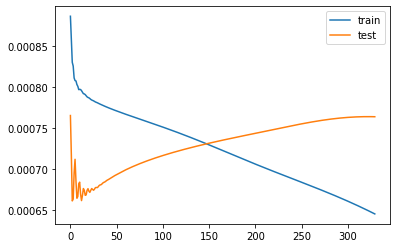

In [ ]:
#Visualizacion del Error
pyplot.plot(LSTMModel_fit.history['loss'], label='train')
pyplot.plot(LSTMModel_fit.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
LSTMModel = create_LSTMmodel(12, learn_rate = 0.01, momentum=0)
LSTMModel_fit = LSTMModel.fit(X_train_LSTM, Y_train_LSTM, validation_data=(X_test_LSTM, Y_test_LSTM),
                              epochs=20, batch_size=72, verbose=0, shuffle=False)

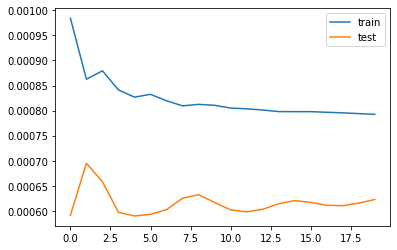

In [ ]:
#Visualizacion del error
pyplot.plot(LSTMModel_fit.history['loss'], label='train')
pyplot.plot(LSTMModel_fit.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
error_Training_LSTM = mean_squared_error(Y_train_LSTM, LSTMModel.predict(X_train_LSTM))
predicted = LSTMModel.predict(X_test_LSTM)
error_Test_LSTM = mean_squared_error(Y_test,predicted)

In [ ]:
test_results.append(error_Test_ARIMA)
test_results.append(error_Test_LSTM)

train_results.append(error_Training_ARIMA)
train_results.append(error_Training_LSTM)

names.append("ARIMA")
names.append("LSTM")

## ANalisis de Resultados

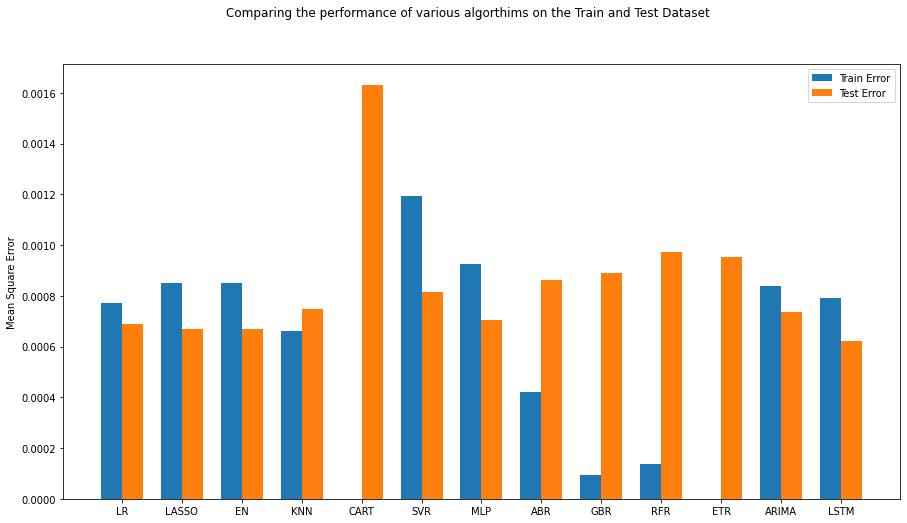

In [ ]:
# Comparar Algoritmos
fig = pyplot.figure()

ind = np.arange(len(names))  
width = 0.35  

fig.suptitle('Comparing the performance of various algorthims on the Train and Test Dataset')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.ylabel('Mean Square Error')
pyplot.show()

Parece que los modelos **lineales**, **KNN**, **ARIMA** y **LSTM** tienen el mejor performance en el test y train.  
Para probar algo nuevo, utilizaremos el modelo ARIMA.

# Tuneo de ARIMA

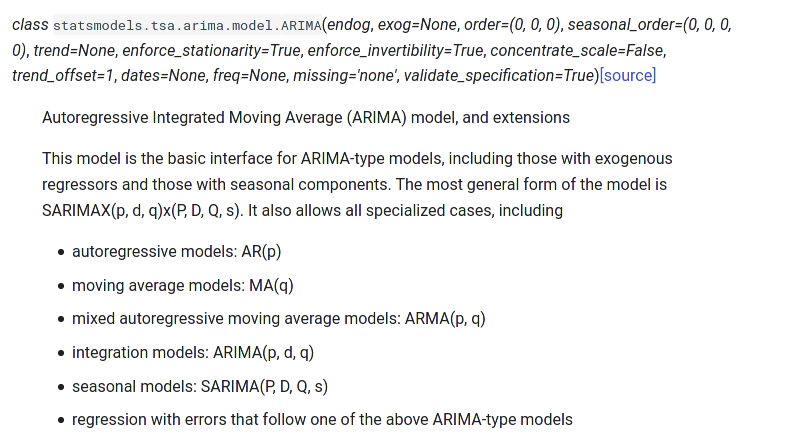

In [ ]:
def evaluate_arima_model(arima_order):
    modelARIMA=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=arima_order)
    model_fit = modelARIMA.fit()
    error = mean_squared_error(Y_train, model_fit.fittedvalues)
    return error
 
# Evaluar
def evaluate_models(p_values, d_values, q_values): 
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)                
                try:
                    mse = evaluate_arima_model(order)                    
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.7f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.7f' % (best_cfg, best_score))

In [ ]:
p_values = [0, 1, 2]
d_values = range(0, 2)
q_values = range(0, 2)
warnings.filterwarnings("ignore")
evaluate_models(p_values, d_values, q_values) 

ARIMA(0, 0, 0) MSE=0.0008376
ARIMA(0, 0, 1) MSE=0.0008370
ARIMA(1, 0, 0) MSE=0.0008372
ARIMA(2, 0, 0) MSE=0.0008188
ARIMA(2, 0, 1) MSE=0.0007410
Best ARIMA(2, 0, 1) MSE=0.0007410


# Finalizacion de Arima

In [ ]:
modelARIMA_tuned=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=[2,0,1])
model_fit_tuned = modelARIMA_tuned.fit()

In [ ]:
predicted_tuned = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
print(mean_squared_error(Y_test,predicted_tuned))

0.0007380038125161113


## Pickles para Guardar Modelos

In [ ]:
# Save Model Using Pickle
from pickle import dump
from pickle import load

# save the model to disk
filename = 'finalized_model_test.sav'
dump(model_fit_tuned, open(filename, 'wb'))

In [ ]:
# open the file for reading
pic_in = open("finalized_model_test.sav", "rb")# load the object from the file into var a
a = load(pic_in)

print(a)

In [ ]:
predicted_tuned = a.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
print(mean_squared_error(Y_test,predicted_tuned))

0.000700301455305329
